In [19]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
import seaborn as sns
from sklearn.metrics import accuracy_score,log_loss,precision_score,f1_score

from mlfinlab.cross_validation.cross_validation import ml_get_train_times,ml_cross_val_score,PurgedKFold
from mlfinlab.feature_importance.importance import (mean_decrease_impurity, mean_decrease_accuracy,
                                                    single_feature_importance, plot_feature_importance)
from mlfinlab.feature_importance.orthogonal import (feature_pca_analysis, get_pca_rank_weighted_kendall_tau,
                                                    get_orthogonal_features,_standardize_df,_get_eigen_vector)
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score

from mlfinlab.backtest_statistics.statistics import (timing_of_flattening_and_flips, average_holding_period,
                                                     bets_concentration, all_bets_concentration,
                                                     drawdown_and_time_under_water, sharpe_ratio,
                                                     information_ratio, probabilistic_sharpe_ratio,
                                                     deflated_sharpe_ratio, minimum_track_record_length)
from mlfinlab.cross_validation.combinatorial import CombinatorialPurgedKFold
from mlfinlab.util.generate_dataset import get_classification_data 


import warnings
warnings.filterwarnings("ignore")

In [2]:
def getTestData(n_features=40,n_informative=10,n_redundant=10,n_samples=10000):
    # generate a random dataset for a classification problem
    #From: Advances in Financial Machine Learning 

    from sklearn.datasets import make_classification
    trnsX,cont=make_classification(n_samples=n_samples,
                                   n_features=n_features,
                                   n_informative=n_informative,
                                   n_redundant=n_redundant,
                                   random_state=0,
                                   shuffle=False)
    df0=pd.DatetimeIndex(periods=n_samples,freq=pd.tseries.offsets.BDay(), end=pd.datetime.today())
    trnsX,cont=pd.DataFrame(trnsX,index=df0), pd.Series(cont,index=df0).to_frame('bin')
    df0=['I_'+str(i) for i in range(n_informative)] + ['R_'+str(i) for i in range(n_redundant)]
    df0+=['N_'+str(i) for i in range(n_features-len(df0))]
    trnsX.columns=df0
    cont['w']=1./cont.shape[0]
    cont['t1']=pd.Series(cont.index,index=cont.index)
    return trnsX,cont

# Feature analysis

1) Generate synthetic Matrix (X,y) and peforme feature analysis: MDI, MDA and SFI

2) Mean Decrease Impurity (MDI) - In sample sample exclusive for tree-based classifiers

"At each node of each decision tree, the selected feature splits the subset it received in such a way that impurity is" [1]

3) Mean Decrease Accuracy (MDA) - Out of sample 

"Mean decrease accuracy (MDA) is a slow, predictive-importance (out-of-sample, OOS)method." [1]

4) Single Feature Analysis (SFI)

"Single feature importance (SFI) is a cross-section predictive-importance (out-of- sample) method. It computes the OOS performance score of each feature in isolation." [1]

[1] - Advances in Financial Machine Learning -Chapter 8

In [3]:
_,cont=getTestData(5,3,2,10)
xx,yy=get_classification_data(n_features=10,n_informative=3,n_redundant=3,n_samples=100,sigma=0.1)
data=xx
data['Y']=yy
yft=data.columns.values[-1]
xft=data.columns.values[:-1]

I - Informative features

R - Redundant features

N - Non-informative features (noise)

Y = Y(I,R)

In [4]:
xdata=data[xft]
ydata=np.sign(data[yft])

n_estimator=1000
max_samples=10
rf=DecisionTreeClassifier(criterion='entropy',max_features=1,#None,
                          class_weight='balanced',min_weight_fraction_leaf=0.0)

rf=BaggingClassifier(base_estimator=rf,n_estimators=n_estimator,max_features=1.
                     #,max_samples=max_samples
                     ,oob_score=True)


rf.fit(xdata,ydata)
print ('Random Forest fitted')

numdays=len(xdata)
base = datetime.today()
t1 = [base - timedelta(days=x) for x in range(numdays,0,-1)]
t1=pd.DataFrame({'t1':t1})
t1=t1.set_index(t1.t1)
t1['t1']=t1['t1']
cv_gen=PurgedKFold(10,t1.t1)

Random Forest fitted


### MDI

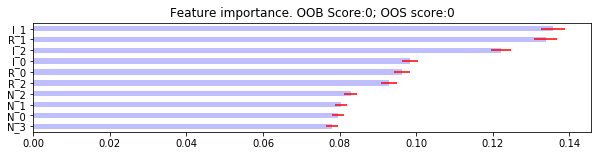

minimum importance: 0.1


In [5]:
imp = mean_decrease_impurity(rf,xft)
plot_feature_importance(imp,0,0)
print ('minimum importance:',1/len(xft))

### MDA

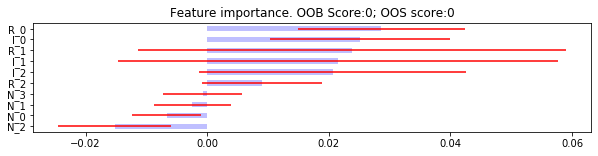

In [6]:
mda=mean_decrease_accuracy(rf,xdata,ydata,cv_gen,scoring=log_loss)

plot_feature_importance(mda,0,0)


### SFI

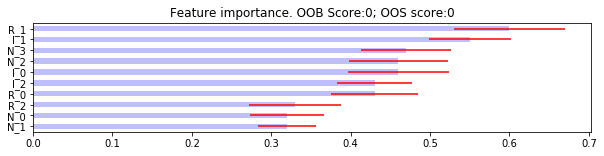

In [7]:
sfi=single_feature_importance(rf,xdata,ydata,cv_gen,scoring=accuracy_score)

plot_feature_importance(sfi,0,0)


# PCA analysis

In [8]:
X=data[xft].copy()
Z=X.sub(X.mean(), axis=1).div(X.std(), axis=1)
ZtZ=pd.DataFrame(np.dot(Z.T,Z),index=X.columns,columns=X.columns)
eVal,eVec=np.linalg.eigh(ZtZ)
idx=eVal.argsort()[::-1]
eVal=eVal[idx]
#eVal=pd.Series(eVal,index=['PC_'+str(i+1) for i in range(eVal.shape[0])])
th=0.999
eVal,eVec=_get_eigen_vector(ZtZ, th)

Xdot = pd.DataFrame(get_orthogonal_features(X,th), index=X.index).add_prefix("PCA_")
Xdot.head()
#eVal=eVal.reset_index()#index=Xdot.index)
#eVal=eVal.reindex(Xdot.columns)
eVal=pd.Series(eVal.values,index=Xdot.columns)

print ('Eigen values:\n')
print (eVal)
print (Xdot.head())

Eigen values:

PCA_0    315.725254
PCA_1    212.699115
PCA_2    122.147075
PCA_3    105.096686
PCA_4     89.461405
PCA_5     78.253880
PCA_6     65.941776
dtype: float64
      PCA_0     PCA_1     PCA_2     PCA_3     PCA_4     PCA_5     PCA_6
0 -1.220564  2.453654  0.358903 -0.547033  0.468912  0.767279  2.162550
1 -1.710996  2.603432  0.989543 -0.253717 -0.174286  0.165884  2.211931
2 -1.814860 -0.155797  0.270369 -1.699174  0.242759 -0.920382  0.211931
3 -1.814034 -0.712837 -1.915729  2.464931  0.692409  0.825922 -0.436053
4 -1.222298  0.071714  2.028305  0.043081  1.635368  0.002890  1.058662


In [9]:
RANDOM_STATE=100
n_estimator=1000
maxsamples=1
rf=DecisionTreeClassifier(criterion='entropy',
                          max_features=1,#None,#1,
                          class_weight='balanced',
                          min_weight_fraction_leaf=0.0)

rf=BaggingClassifier(base_estimator=rf,
                     n_estimators=n_estimator,
                     max_features=1.,
                     #max_samples=maxsamples,
                     oob_score=True)

Y=np.sign(data[yft])
Xpca=Xdot.copy()

base = datetime.today()
numdays=len(Xpca)
t1 = [base - timedelta(days=x) for x in range(numdays,0,-1)]
t1=pd.DataFrame({'t1':t1})
t1=t1.set_index(t1.t1)
t1['t1']=t1['t1']
w=[1/len(cont) for x in range(numdays)]
w=pd.DataFrame({'w':w})
w=w.set_index(w.w)

rf.fit(Xpca,Y)
cv_gen=PurgedKFold(10,t1.t1)

### PCA MDI

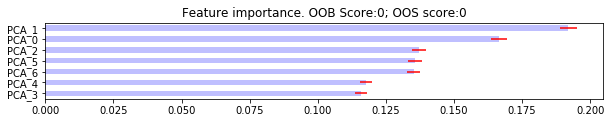

minimum importance: 0.1


{'Pearson': (0.0650505048877553, 0.6569924655395483),
 'Spearman': SpearmanrResult(correlation=0.1327629058554334, pvalue=0.36314763181306553),
 'Kendall': KendalltauResult(correlation=0.082723717734798, pvalue=0.42742367117509616),
 'Weighted_Kendall_Rank': WeightedTauResult(correlation=0.3089990817263545, pvalue=nan)}

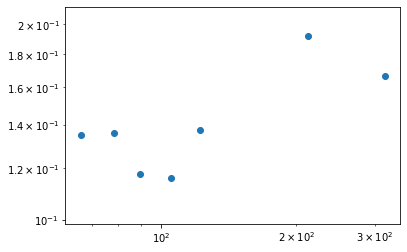

In [10]:
import matplotlib.pyplot as plt
imp = mean_decrease_impurity(rf,Xpca.columns)
plot_feature_importance(imp,0,0)
print ('minimum importance:',1/len(xft))
fig,aux=plt.subplots()
aux.scatter(eVal.loc[imp.index],imp['mean'])
aux.set_yscale('log')
aux.set_xscale('log')
feature_pca_analysis(Xpca,imp)

### PCA MDA

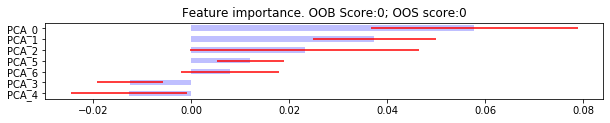

In [11]:
#MDA
imp=mean_decrease_accuracy(rf,Xpca,Y,cv_gen,scoring=log_loss)
plot_feature_importance(imp,0,0)


### PCA SFI

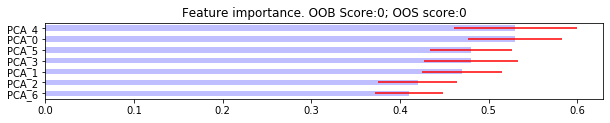

In [12]:
#SFI
imp=single_feature_importance(rf,Xpca,Y,cv_gen,scoring=accuracy_score)
plot_feature_importance(imp,0,0)


# Feature analysis

### Clustering

In [13]:
from mlfinlab.clustering.onc import get_onc_clusters
from mlfinlab.clustering.feature_clusters import get_feature_clusters
from sklearn.model_selection._split import KFold

clusters=get_feature_clusters(data[xft]
                              ,dependence_metric='linear'
                              ,distance_metric=None
                              ,linkage_method=None
                              ,n_clusters=None)
clusters

No feature/s found with low silhouette score. All features belongs to its respective clusters


[['I_1', 'R_1'], ['I_0', 'R_0', 'R_2'], ['I_2', 'N_0', 'N_1', 'N_2', 'N_3']]

In [14]:
clf_base = DecisionTreeClassifier(criterion='entropy'
                                  ,max_features=1
                                  ,class_weight='balanced'
                                  ,min_weight_fraction_leaf=0)

clf = BaggingClassifier(base_estimator=clf_base
                        ,n_estimators=1000
                        ,max_features=1.
                        ,max_samples=1.
                        ,oob_score=True
                        ,n_jobs=-1)
X=data[xft]
y=np.sign(data[yft])
fit = clf.fit(X,y)
cvGen = KFold(n_splits=10)
oos_score = ml_cross_val_score(clf, X, y, cv_gen=cvGen, scoring=log_loss).mean()

##### MDI cluster

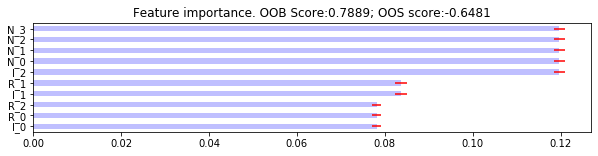

In [15]:
clustered_mdi_imp = mean_decrease_impurity(clf,X.columns,clustered_subsets=clusters)
plot_feature_importance(clustered_mdi_imp,oob_score=clf.oob_score_, oos_score=oos_score)

##### MDA cluster

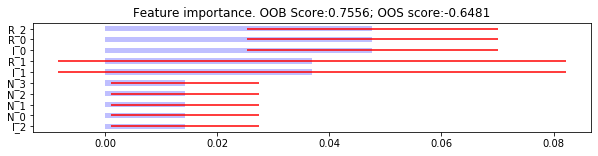

In [16]:
clustered_mda_imp = mean_decrease_accuracy(clf,X,y
                                           ,cv_gen=cvGen
                                           ,clustered_subsets=clusters
                                           ,random_state=0
                                           ,scoring=log_loss)
plot_feature_importance(clustered_mda_imp,oob_score=clf.oob_score_, oos_score=oos_score)

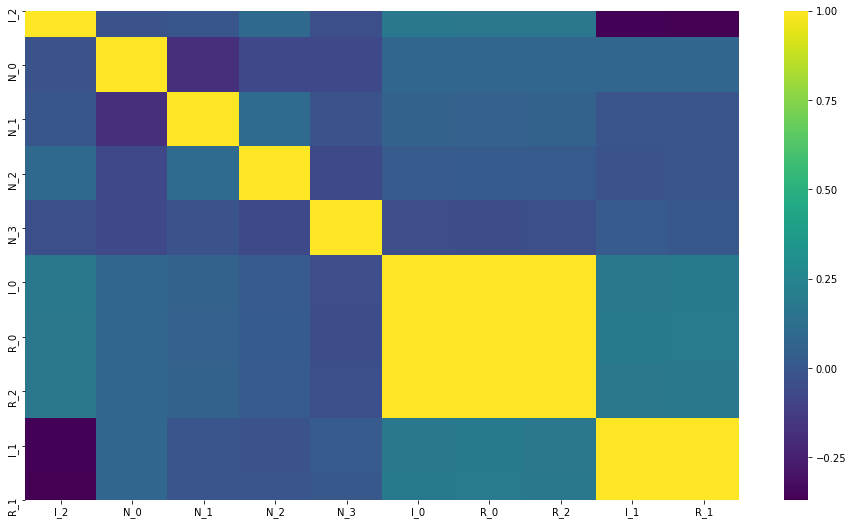

In [20]:
corr0,clstrs,silh = get_onc_clusters(X.corr())
plt.figure(figsize=(16,9))
sns.heatmap(corr0,cmap='viridis')